In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Importing Data

In [2]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import plotly.express as px
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore')

In [3]:
titanic = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
titanic[['Deck', 'Number', 'Side']] = titanic['Cabin'].str.split('/', expand = True)
titanic = titanic.drop(columns = ['Cabin'])
titanic

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


In this section we are selecting our features.

In [4]:
y_full = titanic.Transported
X_full = titanic.drop(columns = ['Transported'])
low_cardinality_cols = [col for col in X_full.columns if X_full[col].dtype == 'object' and X_full[col].nunique() < 10]
numerical_cols = [col for col in X_full.columns if X_full[col].dtype in ['int64', 'float64']]
features = low_cardinality_cols + numerical_cols
X_full = X_full[features]
for colname in X_full.select_dtypes('object'):
    X_full[colname], _ = X_full[colname].factorize()
discrete_features = X_full.dtypes == int
X_full.dropna(inplace = True)
y_full = y_full.loc[X_full.index]

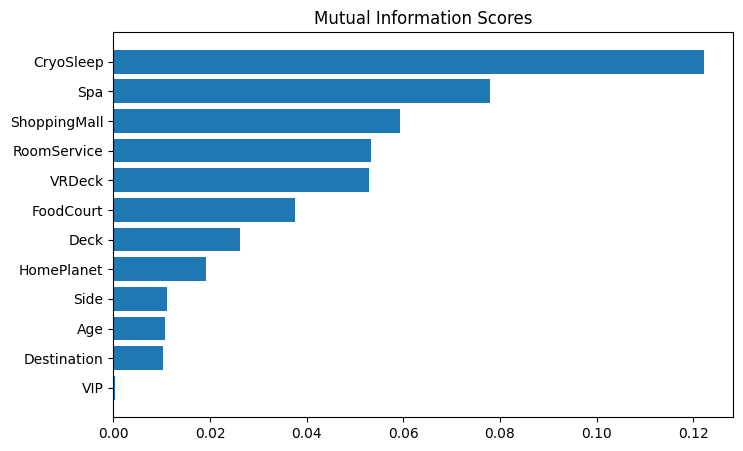

In [5]:
#Getting Mutual Information Scores
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_full, y_full, discrete_features)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [6]:
pca = PCA(n_components = 3)
components = pca.fit_transform(X_full)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=y_full.apply(lambda x: 'Transported' if x == 1 else 'Not Transported')
)
fig.update_traces(diagonal_visible=True)
fig.show()

In [7]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color = y_full.apply(lambda x: 'Transported' if x == 1 else 'Not Transported'),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [8]:
pca = PCA(n_components = 6)
components = pca.fit_transform(X_full)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full,
                                                      test_size = 0.33, random_state = 26)

In [10]:
#Logisitic Regression
logr = LogisticRegression()
logr.fit(X_train, y_train)
print("Logistic Regression score: {}\n".format(logr.score(X_valid, y_valid)))
#K Neighbors
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_train, y_train)
print("K Neighbor's score: {}\n".format(neigh.score(X_valid, y_valid)))
#SVC Classification
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability = True))
clf.fit(X_train, y_train)
y_predictions_svc = clf.predict(X_valid)
print("SVC score: {}".format(clf.score(X_valid, y_valid)))

Logistic Regression score: 0.7852882703777336

K Neighbor's score: 0.7872763419483101

SVC score: 0.7932405566600398


In [11]:
pca = PCA(n_components = 3)
decomposed_X_train = pca.fit_transform(X_train)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability = True))
clf.fit(decomposed_X_train, y_train)
y_predictions_svc = clf.predict(pca.transform(X_valid))

In [12]:
correct_predictions = y_valid == y_predictions_svc
components = pca.transform(X_valid)
labels = {
    str(i): f"PC {i+1}"
    for i in range(3)
}

percent_correct = (correct_predictions.sum() / len(correct_predictions)) * 100.

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color = correct_predictions.apply(lambda x: 'Correct' if x == 1 else 'Incorrect'),
    title=f'Total Percent Correct: {percent_correct:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [13]:
probabilities = clf.predict_proba(components)[:,[0]].squeeze()
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color = probabilities,
    title=f'Total Percent Correct: {percent_correct:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [14]:
import plotly.graph_objects as go
import numpy as np

x, y, z = tuple(np.split(components, 3, 1))
x = x.squeeze()
y = y.squeeze()
z = z.squeeze()

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=4,
        color= probabilities,                # set color to an array/list of desired values
        colorscale='Viridis'   # choose a colorscale
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [15]:
cat_col = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 
           'Deck', 'Side']
num_col = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [16]:
# making pipeline
imputer = SimpleImputer()
scaler = StandardScaler()
encoder = ce.TargetEncoder(cols=cat_col)
# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(imputer,scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

# choosing model
model_name = XGBClassifier(             
        n_estimators=100
        )

# giving all values to pipeline
pipe = make_pipeline(preprocessor, model_name)
pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_valid = pipe.predict(X_valid)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"VALID: {accuracy_score(y_valid, y_pred_valid)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"VALID: {balanced_accuracy_score(y_valid, y_pred_valid)}")

Accuracy:
TRAIN: 0.9212536728697356
VALID: 0.7992047713717694

Balanced Accuracy:
TRAIN: 0.9211750395235683
VALID: 0.7993111708956423


In [17]:
pipe.fit(X_full, y_full)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  Pipeline(steps=[('targetencoder',
                                                                   TargetEncoder(cols=['HomePlanet',
                                                                                       'CryoSleep',
                                                                                       'Destination',
                                                                                       'VIP',
                                                                                       'Deck',
                                                                                       'Side']))...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [18]:
# Load the test dataset
X_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = X_test.PassengerId

# Replace NaN values with zero
X_test[['VIP', 'CryoSleep']] = X_test[['VIP', 'CryoSleep']].fillna(value=0)

# Creating New Features - Deck, Cabin_num and Side from the column Cabin and remove Cabin
X_test[["Deck", "Num", "Side"]] = X_test["Cabin"].str.split("/", expand=True)
X_test = X_test.drop(columns = ['Cabin', 'Num'], axis=1)

# Convert boolean to 1's and 0's
for colname in X_test.select_dtypes('object'):
    X_test[colname], _ = X_test[colname].factorize()

# Get the predictions for testdata
n_predictions = pipe.predict(X_test) == 1
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,True
4,0023_01,True


In [19]:
output.to_csv('submission.csv', index=False)
output.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,True
4,0023_01,True
